# 🐜 Ant Colony Optimization (ACO) for 1-D Bin Packing

This notebook implements and evaluates an **Ant Colony Optimization (ACO)** algorithm  
to minimize the number of bins required to pack a set of items (OR-Library Bin Packing dataset).

We:
- Parse OR-Library data (`binpack1–8.txt`),
- Perform exploratory data analysis (EDA),
- Implement a per-item ACO model (pheromone + heuristic),
- Evaluate across multiple datasets,
- Visualize convergence and packing results,
- Export summary results as a CSV.


# ACO — Ant Colony Optimization for 1-D Bin Packing

Purpose: metaheuristic optimization to minimize the number of bins needed to pack items.

<ol> <li><b>Items:</b> integer sizes <code>w</code> of length <code>n</code></li> <li><b>Capacity:</b> bin capacity <code>C</code> (per instance)</li> <li><b>Objective:</b> minimize bins used <code>B</code> (tie-break by total unused space)</li> <li><b>Algorithm parameters:</b></li> <ol> <li><code>alpha (α)</code>: pheromone weight</li> <li><code>beta (β)</code>: heuristic weight</li> <li><code>rho (ρ)</code>: evaporation rate</li> <li><code>Q</code>: deposit strength</li> <li><code>ants</code>: solutions per iteration</li> <li><code>iters</code>: number of iterations</li> <li><code>seed</code>, <code>record_history</code></li> </ol> </ol>

1) Preprocessing and setup

Parse each OR-Library file → get (C, n, [opt_bins]) and the n sizes.

Show quick EDA (n, C, total weight, lower bound ≈ ceil(sum(w)/C); histogram of sizes).

Initialize pheromone vector tau (length n, one value per item).

Define heuristic eta per item (we use item size: larger items favored earlier).

2) Helper components

Decoder (tight-fit): given an item order, place each item into the fullest bin that can still accommodate it; otherwise open a new bin. Always feasible (load ≤ C).

Cost function: cost = (B, unused) where B = bins used and unused = total empty space across all bins.

3) Initialization

Set tau[i] = 1 for all items i.

Set global best to “infinite” cost; prepare history lists if needed.

4) Main ACO loop

For each iteration:

For each ant:

Build a permutation without replacement. At each step choose item j with probability proportional to tau[j]^alpha * eta[j]^beta.

Decode the permutation with tight-fit to get a feasible packing.

Evaluate cost = (B, unused) and keep the best ant of the iteration.

Pheromone update: evaporate tau ← (1 − rho) * tau, then deposit on items used by the iteration-best solution with Δ = Q / max(1, B).

Update global best and append to history.

5) Finish

Return best solution found (bins and loads), best cost (B, unused), convergence history, and runtime.

Build a results table over all instances:
Instance, n_items, Capacity, Best_bins, Unused_space, Runtime (s), opt_bins, gap_to_opt (and save CSV).

Notes

Higher beta → greedier (often faster early improvement).

Higher rho → more exploration (less stagnation).

More ants/iters → better solutions, longer runtime.

Using a per-item pheromone vector (instead of an n×n edge matrix) keeps memory low and matches the order-based decoder well.

## 1. Imports

In [883]:
import bisect
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random, math, time
from dataclasses import dataclass
from typing import List, Dict, Tuple
from IPython.display import display
from dataclasses import dataclass
import numpy as np, random, math
import copy
import seaborn as sns

# file paths (download from https://people.brunel.ac.uk/~mastjjb/jeb/orlib/binpackinfo.html)
BINPACK1 = Path("./data/binpacking/binpack1.txt")
BINPACK2 = Path("./data/binpacking/binpack2.txt")
BINPACK3 = Path("./data/binpacking/binpack3.txt")
BINPACK4 = Path("./data/binpacking/binpack4.txt")
BINPACK5 = Path("./data/binpacking/binpack5.txt")
BINPACK6 = Path("./data/binpacking/binpack6.txt")
BINPACK7 = Path("./data/binpacking/binpack7.txt")
BINPACK8 = Path("./data/binpacking/binpack8.txt")

%matplotlib inline


In [884]:
# ACO FINAL — Configuration
RUN_ALL_INSTANCES = False  # False = first instance per file (fast). True = all instances inside each file.
SAVE_FIGS = False          # Save plots to ./figs/
FIG_DIR = Path("./figs"); FIG_DIR.mkdir(exist_ok=True)

In [885]:
all_paths = [BINPACK1, BINPACK2, BINPACK3, BINPACK4, BINPACK5, BINPACK6, BINPACK7, BINPACK8]
all_paths = [p for p in all_paths if p.exists()]  # keep only present files

### 1.1 Internal helper functions

Read all numeric tokens:

In [886]:
def _read_int_tokens(path: Path) -> List[int]:
    toks = []
    with open(path, "r") as f:
        for t in f.read().split():
            try:
                toks.append(int(float(t)))
            except ValueError:
                pass
    return toks

Parser for OR-Library binpack*.txt files. Reads all instances from a file, selects first and converts each instance to a Pandas `DataFrame`.
<br><br>
Each OR-Library file (binpack1–8) contains multiple bin packing instances.
<br>
We parse capacities (C), item sizes (w_i), and optional known optimal bin counts (opt_bins).

In [887]:
def parse_binpack_all(path: Path) -> list[dict]:
    """
    Parse Beasley's OR-Library bin packing instances (binpack1..8).
    Format:
        <#instances>
         tXXX_00
          C n opt_bins
          <n item sizes>
    """
    toks = _read_int_tokens(path)
    p = 0
    if p >= len(toks):
        raise ValueError(f"{path} has no numeric tokens")

    num_instances = int(toks[p]); p += 1
    out = []
    name_base = path.stem

    for k in range(1, num_instances + 1):
        # Each header is: C n opt_bins
        if p + 2 >= len(toks):
            break
        C = int(toks[p]); n = int(toks[p + 1]); opt_bins = int(toks[p + 2])
        p += 3

        sizes = toks[p:p + n]
        p += n

        out.append({
            "name": f"{name_base}#{k}",
            "capacity": C,
            "weights": sizes,
            "opt_bins": opt_bins
        })

    return out



def parse_binpack_first(path: Path) -> dict:
    arr = parse_binpack_all(path)
    if not arr:
        raise ValueError(f"No instances parsed from {path}")
    return arr[0]


def instance_to_df(inst: dict) -> pd.DataFrame:
    df = pd.DataFrame({
        "Item": np.arange(1, len(inst["weights"]) + 1),
        "Size": inst["weights"]
    })
    df.attrs["capacity"] = inst["capacity"]
    df.attrs["name"] = inst["name"]
    df.attrs["opt_bins"] = inst.get("opt_bins")
    return df

def describe_instance(inst: dict):
    """
    Summarize the contents of an instance.
    """
    w = np.array(inst["weights"], dtype=int)
    C = int(inst["capacity"])
    lb = int(np.ceil(w.sum() / C))
    opt = inst.get("opt_bins")
    opt_txt = f", opt_bins={opt}" if opt else ""
    print(f"{inst['name']}: n={len(w)}, C={C}, total_weight={w.sum()}, lower_bound≈{lb}{opt_txt}")

In [888]:
def iter_instances(paths, run_all: bool = False):
    """Yield instances across all files. If run_all=True, yield every sub-instance; else only the first."""
    for p in paths:
        if not p.exists():
            continue
        if run_all:
            for inst in parse_binpack_all(p):
                yield p.stem, inst
        else:
            yield p.stem, parse_binpack_first(p)

def lower_bound(weights, C):
    return int(np.ceil(np.sum(weights) / C))

def verify_solution(capacity: int, bins: list[list[int]]) -> None:
    """Assert all bins are feasible."""
    for idx, b in enumerate(bins, 1):
        if sum(b) > capacity:
            raise AssertionError(f"Bin {idx} infeasible: load={sum(b)} > C={capacity}")


Create tables with top items of each instance:

In [889]:
def binpack_tables(top_n: int = 10) -> dict[str, pd.DataFrame]:
    """
    Load the first instance from each OR-Library binpack file that exists,
    print a short summary, and return them in a dict of DataFrames.
    """
    paths = [BINPACK1, BINPACK2, BINPACK3, BINPACK4, BINPACK5, BINPACK6, BINPACK7, BINPACK8]
    paths = [p for p in paths if p.exists()]

    datasets: dict[str, pd.DataFrame] = {}

    for p in paths:
        inst = parse_binpack_first(p)
        df = instance_to_df(inst)

        n = len(inst["weights"])
        C = inst["capacity"]
        lb = int(np.ceil(sum(inst["weights"]) / C))
        opt = inst.get("opt_bins")

        label = p.stem  # e.g., "binpack1"
        datasets[label] = df

        print(f"\n=== {label} ===")
        print(f"{df.attrs['name']}: n={n}, capacity={C}, lower_bound≈{lb}, opt_bins={opt}")
        print(df.head(top_n))

    return datasets

# Example usage
bp = binpack_tables(top_n=10)



=== binpack1 ===
binpack1#1: n=120, capacity=150, lower_bound≈48, opt_bins=48
   Item  Size
0     1    42
1     2    69
2     3    67
3     4    57
4     5    93
5     6    90
6     7    38
7     8    36
8     9    45
9    10    42

=== binpack2 ===
binpack2#1: n=250, capacity=150, lower_bound≈99, opt_bins=99
   Item  Size
0     1    42
1     2    69
2     3    67
3     4    57
4     5    93
5     6    90
6     7    38
7     8    36
8     9    45
9    10    42

=== binpack3 ===
binpack3#1: n=500, capacity=150, lower_bound≈198, opt_bins=198
   Item  Size
0     1    42
1     2    69
2     3    67
3     4    57
4     5    93
5     6    90
6     7    38
7     8    36
8     9    45
9    10    42

=== binpack4 ===
binpack4#1: n=1000, capacity=150, lower_bound≈399, opt_bins=399
   Item  Size
0     1    42
1     2    69
2     3    67
3     4    57
4     5    93
5     6    90
6     7    38
7     8    36
8     9    45
9    10    42

=== binpack5 ===
binpack5#1: n=60, capacity=100, lower_bound≈2

### 1.2 Item size for each instance

Histogram of items in each instance, displaying the distribution of items on size.

binpack1#1: n=120, C=150, total_weight=7078, lower_bound≈48, opt_bins=48


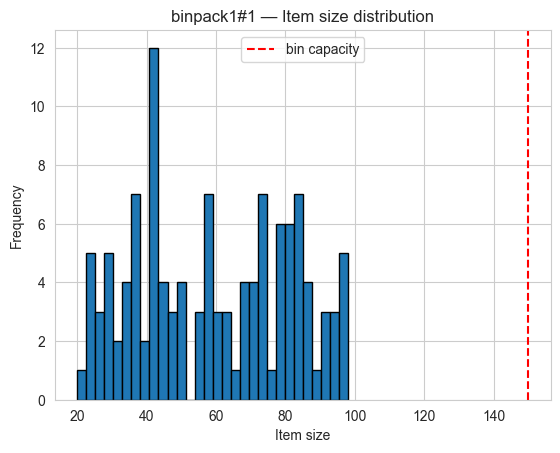

binpack2#1: n=250, C=150, total_weight=14783, lower_bound≈99, opt_bins=99


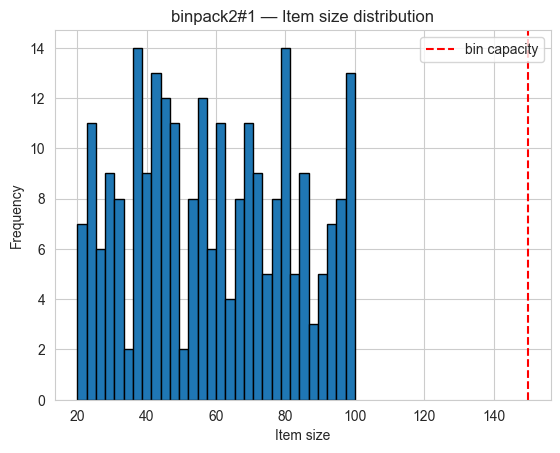

binpack3#1: n=500, C=150, total_weight=29637, lower_bound≈198, opt_bins=198


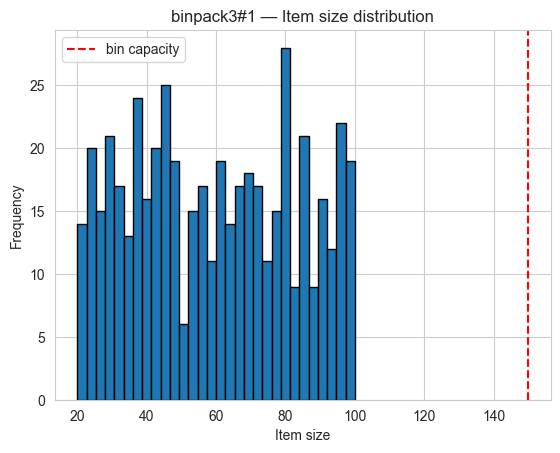

binpack4#1: n=1000, C=150, total_weight=59764, lower_bound≈399, opt_bins=399


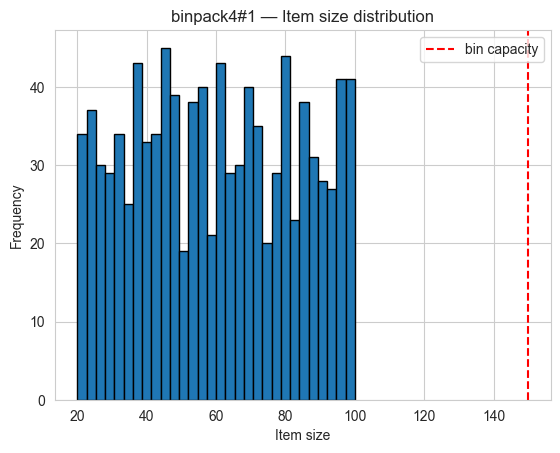

binpack5#1: n=60, C=100, total_weight=1975, lower_bound≈20, opt_bins=20


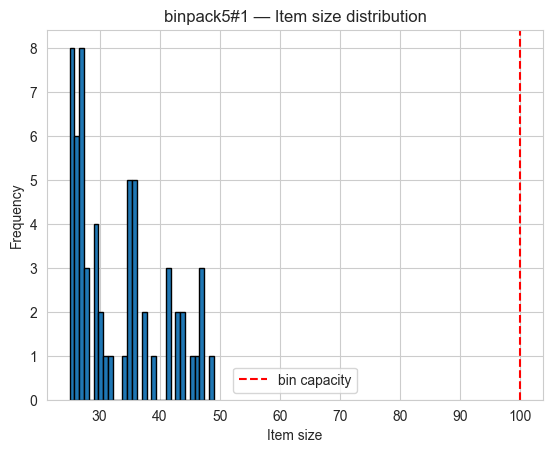

binpack6#1: n=120, C=100, total_weight=3951, lower_bound≈40, opt_bins=40


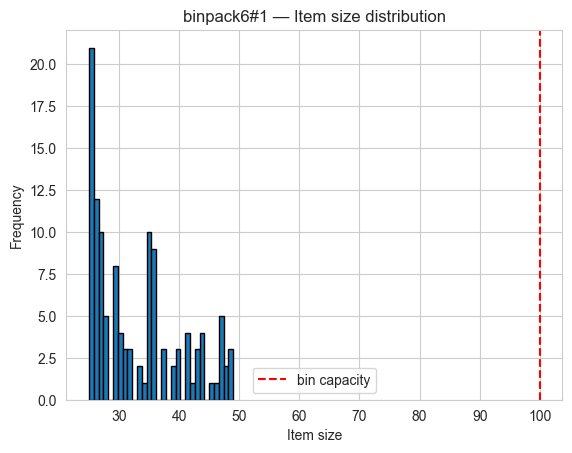

binpack7#1: n=249, C=100, total_weight=8200, lower_bound≈82, opt_bins=83


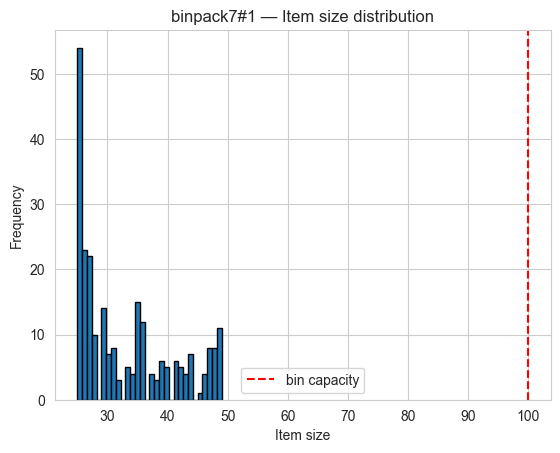

binpack8#1: n=501, C=100, total_weight=16487, lower_bound≈165, opt_bins=167


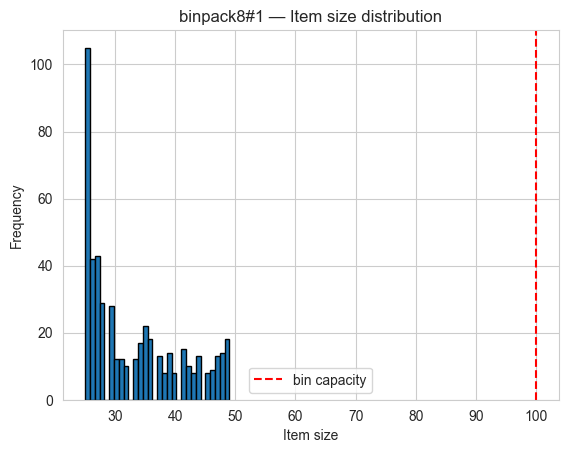

In [890]:
for path in [BINPACK1, BINPACK2, BINPACK3, BINPACK4, BINPACK5, BINPACK6, BINPACK7, BINPACK8]:
    inst = parse_binpack_first(path)
    describe_instance(inst)
    df = instance_to_df(inst)

    plt.figure()
    plt.hist(df["Size"], bins=30, edgecolor="black")
    plt.axvline(df.attrs["capacity"], color="red", linestyle="--", label="bin capacity")
    plt.title(f"{df.attrs['name']} — Item size distribution")
    plt.xlabel("Item size")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


In [891]:
for name, inst in iter_instances(all_paths, run_all=True):
    if "binpack6" in name:
        describe_instance(inst)


binpack6#1: n=120, C=100, total_weight=3951, lower_bound≈40, opt_bins=40
binpack6#2: n=120, C=100, total_weight=3947, lower_bound≈40, opt_bins=40
binpack6#3: n=120, C=100, total_weight=3951, lower_bound≈40, opt_bins=40
binpack6#4: n=120, C=100, total_weight=3946, lower_bound≈40, opt_bins=40
binpack6#5: n=120, C=100, total_weight=3947, lower_bound≈40, opt_bins=40
binpack6#6: n=120, C=100, total_weight=3949, lower_bound≈40, opt_bins=40
binpack6#7: n=120, C=100, total_weight=3949, lower_bound≈40, opt_bins=40
binpack6#8: n=120, C=100, total_weight=3950, lower_bound≈40, opt_bins=40
binpack6#9: n=120, C=100, total_weight=3945, lower_bound≈40, opt_bins=40
binpack6#10: n=120, C=100, total_weight=3951, lower_bound≈40, opt_bins=40
binpack6#11: n=120, C=100, total_weight=3944, lower_bound≈40, opt_bins=40
binpack6#12: n=120, C=100, total_weight=3950, lower_bound≈40, opt_bins=40
binpack6#13: n=120, C=100, total_weight=3951, lower_bound≈40, opt_bins=40
binpack6#14: n=120, C=100, total_weight=3946, l

## 2. Define parameters and helper function for ACO algorithm
- Parameter definitions (`ACOParams`)
- Core helper functions (tight-fit decoder, cost evaluation)

In [892]:
#| Parameter                       | Symbol | Suggested Range |
#| ------------------------------- | ------ | --------------- |
#| Number of ants                  | m      | 10–50           |
#| Evaporation rate                | ρ      | 0.2–0.5         |
#| α (pheromone importance)        | α      | 1–2             |
#| β (heuristic importance)        | β      | 2–5             |
#| q₀ (deterministic choice prob.) | q₀     | 0.6–0.8         |
#| Initial pheromone               | τ₀     | 0.1–1.0         |
#| Iterations before reset         | —      | 20–50           |

# params
@dataclass
class ACOParams:
    alpha: float = 1.5    # pheromone weight
    beta: float  = 2.5    # heuristic weight (favor bigger items)
    rho: float   = 0.08   # evaporation
    Q: float     = 2000     # deposit strength
    ants: int    = 25    # solutions per iteration
    iters: int   = 150    # iterations
    seed: int    = 123    # reproducible
    stlim: int   = 100
    record_history: bool = True

PARAM_SETS = {
    # 🧩 Set 1 — Balanced (default “safe” mode)
    # Works consistently on binpack1–8.
    "balanced": ACOParams(
        alpha=1.2,   # mild pheromone use
        beta=3.0,    # strong heuristic guidance
        rho=0.10,    # moderate evaporation
        Q=1200,      # balanced reinforcement
        ants=20,
        iters=150
    ),

    # 🌍 Set 2 — Exploration (wide search)
    # Designed to escape early stagnation and explore diverse permutations.
    "exploration": ACOParams(
        alpha=0.8,   # weak pheromone -> randomness
        beta=3.5,    # rely heavily on heuristic
        rho=0.20,    # strong evaporation (resets more often)
        Q=800,       # smaller deposit (gentle updates)
        ants=30,
        iters=200
    ),

    # 🎯 Set 3 — Exploitation (“reach optimal” mode)
    # For pushing cost from near-optimal → optimal bins.
    "exploitation": ACOParams(
        alpha=1.5,   # strong pheromone (focus memory)
        beta=2.0,    # less greedy, more trust pheromones
        rho=0.05,    # low evaporation (persistent paths)
        Q=2000,      # high reward for best solutions
        ants=15,
        iters=250
    )
}


# tight-fit
def first_fit_tight(weights, capacity):
    """Greedy tight-fit heuristic (optimized for speed and clarity)."""
    bins = []
    loads = []

    for w in weights:
        best_idx = -1
        best_slack = capacity + 1  # sentinel high value

        for i, load in enumerate(loads):
            if load + w > capacity:
                continue
            slack = capacity - (load + w)
            if slack < best_slack:
                best_slack = slack
                best_idx = i
                if best_slack == 0:  # perfect fit shortcut
                    break

        if best_idx == -1:
            bins.append([w])
            loads.append(w)
        else:
            bins[best_idx].append(w)
            loads[best_idx] += w

    return bins, loads


def solution_cost(loads, capacity, lam=1.0):
    """Continuous cost: number of bins + normalized unused capacity."""
    loads = np.asarray(loads, dtype=float)
    num_bins = len(loads)
    unused = (capacity - loads).sum() / capacity
    return num_bins + lam * unused


def local_repair(bins, capacity):
    """Repack items greedily (tight-fit) to improve load balance."""
    # Flatten bins efficiently
    items = [w for b in bins for w in b]
    items.sort(reverse=True)
    return first_fit_tight(items, capacity)



## 3. ACO algorithm

Main `aco_binpack()` function that builds solutions, updates pheromone, and tracks convergence.

In [893]:
def aco_binpack_rank(weights, capacity, p: ACOParams, stlim=40):
    """
    ACO Bin Packing with rank-based + normalized pheromone update.
    Includes bin reconstruction for interpretability.
    Optimized for small-instance bin packing benchmarks.
    """
    import numpy as np, random, time

    random.seed(p.seed)
    np.random.seed(p.seed)

    W = np.asarray(weights, dtype=float)
    n = len(W)

    tau = np.full((n, n), 1.0, dtype=float)

    best_cost = np.inf
    best_bins = best_loads = None
    best_order = list(range(n))
    history_best = []
    tau_std_hist = []
    mean_cost_hist = []
    no_improvement = 0
    eps = 1e-9

    start_time = time.time()

    for iteration in range(p.iters):
        ant_results = []
        costs = []

        # ---- Each ant constructs a permutation ----
        for _ in range(p.ants):
            mask = np.ones(n, dtype=bool)
            order = []
            current = None

            for _ in range(n):
                remaining = np.where(mask)[0]
                eta = (W[remaining] / capacity) ** p.beta

                if current is None:
                    score = eta
                else:
                    score = (tau[current, remaining] ** p.alpha) * eta

                score_sum = score.sum()
                if score_sum <= 0 or not np.isfinite(score_sum):
                    # fallback: uniform probability
                    probs = np.full_like(score, 1 / len(score))
                else:
                    probs = score / score_sum

                # Numerical safety: re-normalize and clip
                probs = np.clip(probs, 1e-12, 1.0)
                probs /= probs.sum()

                j = np.random.choice(remaining, p=probs)

                order.append(j)
                mask[j] = False
                current = j

            perm = W[order]
            bins, loads = first_fit_tight(perm, capacity)
            cost = solution_cost(loads, capacity)
            ant_results.append({"order": order, "cost": cost, "bins": bins, "loads": loads})
            costs.append(cost)

        mean_cost = np.mean(costs)
        it_best = min(costs)
        it_best_idx = np.argmin(costs)
        it_best_ant = ant_results[it_best_idx]

        # ---- Adaptive Evaporation ----
        rho_eff = p.rho * (2.5 if no_improvement > stlim // 3 else 1.0)
        tau *= (1.0 - min(0.5, rho_eff))

        # ---- Rank-based + normalized pheromone update ----
        costs_arr = np.array(costs)
        c_min, c_max = costs_arr.min(), costs_arr.max()
        denom = (c_max - c_min + eps)
        ants_sorted = sorted(ant_results, key=lambda x: x["cost"])

        for rank, ant in enumerate(ants_sorted):
            w = (len(ants_sorted) - rank) / len(ants_sorted)
            norm_c = (ant["cost"] - c_min) / denom
            reward = p.Q * w * (1.0 - norm_c)
            for a, b in zip(ant["order"][:-1], ant["order"][1:]):
                tau[a, b] += reward / n

        # ---- Global best tracking + reconstruction ----
        if it_best < best_cost:
            best_cost = it_best
            best_bins = it_best_ant["bins"]
            best_loads = it_best_ant["loads"]
            best_order = it_best_ant["order"]
            no_improvement = 0
        else:
            no_improvement += 1

        # ---- Record stats ----
        history_best.append(best_cost)
        tau_std_hist.append(tau.std())
        mean_cost_hist.append(mean_cost)

        if iteration % 10 == 0:
            print(f"iter {iteration:03d} | best={best_cost:.3f} | mean={mean_cost:.3f} | τ.std={tau.std():.4f}")

        if no_improvement >= stlim:
            print(f"⚠️ Stagnation detected. Early stop at iter {iteration}")
            break

    elapsed = time.time() - start_time
    print(f"✅ Finished ACO | Best cost={best_cost:.3f} | Runtime={elapsed:.2f}s")

    # ---- Final reconstruction for clarity ----
    final_perm = W[best_order]
    final_bins, final_loads = first_fit_tight(final_perm, capacity)

    return {
        "best_cost": best_cost,
        "best_bins": final_bins,
        "best_loads": final_loads,
        "best_order": best_order,
        "history_best": history_best,
        "history_mean": mean_cost_hist,
        "tau_std": tau_std_hist,
    }


## 4. Run Experiment

We set parameters, toggle whether to run *all* sub-instances or only the first per file,
and compute the final results table.


In [894]:
import time, copy, pandas as pd
from pathlib import Path

def run_experiments(
    all_paths,
    param_sets,
    runs=10,
    test_mode=False,
    solver=None,  # e.g. aco_binpack_rank or aco_binpack_old
):
    """
    Enhanced experiment runner for the improved ACO Bin Packing solver.
    Collects detailed convergence, pheromone, and runtime statistics.

    Args:
        all_paths: list of Path objects (input files)
        param_sets: dict[str, ACOParams]
        runs: int, repetitions per parameter set
        test_mode: if True, runs one small instance only
        solver: callable, ACO solver function
    """
    if solver is None:
        raise ValueError("Please specify a solver (e.g., aco_binpack_rank).")

    results = []
    t0 = time.time()

    # ==============================================================
    # Per-instance stagnation limits (added)
    # ==============================================================
    STLIM_MAP = {
        "binpack1": 35,
        "binpack2": 40,
        "binpack3": 45,
        "binpack4": 50,
        "binpack5": 55,
        "binpack6": 60,
        "binpack7": 65,
        "binpack8": 70,
    }

    # if test_mode TRUE
    if test_mode:
        test_path = next((p for p in all_paths if "binpack2" in str(p)), None)
        if test_path is None or not test_path.exists():
            raise FileNotFoundError("binpack2.txt not found in the given paths.")
        instances = [("binpack2", parse_binpack_first(test_path))]
        chosen_param_sets = {"balanced": param_sets["balanced"]}
        runs = 2
        print("⚙️ TEST MODE: binpack2 × 'balanced' params × 2 runs\n")
    else:
        instances = list(iter_instances(all_paths))
        chosen_param_sets = param_sets
        print(f"🚀 Running full experiment: {len(instances)} instances × {len(chosen_param_sets)} param sets × {runs} runs\n")

    total_jobs = len(instances) * len(chosen_param_sets) * runs
    job_count = 0

    # ==============================================================
    # Main experiment loop
    # ==============================================================
    for instance_name, inst in instances:
        weights, capacity = inst["weights"], inst["capacity"]
        stlim = STLIM_MAP.get(instance_name, 50)  # <-- added line
        print(f"Initiating runs: {instance_name} (stlim={stlim})")

        for param_name, params in chosen_param_sets.items():
            print((f"Usings param set: {param_name}"))
            for run_id in range(1, runs + 1):
                print(f"Seed: {run_id} | Instance: {instance_name} | n: {len(weights)} | C: {capacity}")
                print(f"Known best: {inst['opt_bins']}")
                job_count += 1

                # reproducible seed per (instance, param set, run)
                p = copy.deepcopy(params)
                p.seed = abs(hash((instance_name, param_name, run_id))) % 10_000

                start = time.time()
                res = solver(weights, capacity, p, stlim=stlim)
                elapsed = time.time() - start

                # Graceful metric extraction
                best_cost = res.get("best_cost")
                best_bins = res.get("best_bins", None)
                best_loads = res.get("best_loads", None)
                history_best = res.get("history_best", res.get("history_cost", []))
                history_mean = res.get("history_mean", None)
                tau_std = res.get("tau_std", None)

                # Derived metrics
                num_bins = len(best_bins) if best_bins is not None else None
                unused_cap = (
                    sum(capacity - l for l in (best_loads or []))
                    if best_loads
                    else None
                )

                results.append({
                    "instance": instance_name,
                    "param_set": param_name,
                    "run": run_id,
                    "best_cost": best_cost,
                    "num_bins": num_bins,
                    "unused_capacity": unused_cap,
                    "runtime_s": round(elapsed, 4),
                    "history_best": history_best,
                    "history_mean": history_mean,
                    "tau_std": tau_std,
                })

                # Controlled logging
                if job_count % max(1, total_jobs // 10) == 0 or job_count == total_jobs:
                    print(f"[{job_count}/{total_jobs}] {instance_name} | {param_name} | run {run_id} "
                          f"=> cost={best_cost:.3f} | bins={num_bins} | time={elapsed:.2f}s")

    # ==============================================================
    # Compile results
    # ==============================================================
    df_results = pd.DataFrame(results)

    print(f"\nAll experiments complete in {time.time() - t0:.2f}s")
    print(f"Collected {len(df_results)} results from {total_jobs} runs")

    # Optional aggregate metrics
    agg = (
        df_results.groupby(["instance", "param_set"])
        .agg(
            mean_cost=("best_cost", "mean"),
            std_cost=("best_cost", "std"),
            mean_runtime=("runtime_s", "mean"),
            mean_bins=("num_bins", "mean"),
        )
        .reset_index()
    )

    print("\nSummary of mean results by instance and parameter set:\n")
    print(agg.round(3).to_string(index=False))

    return df_results


In [895]:
df_results = run_experiments(all_paths, PARAM_SETS,test_mode=False, solver=aco_binpack_rank)

🚀 Running full experiment: 8 instances × 3 param sets × 10 runs

Initiating runs: binpack1 (stlim=35)
Usings param set: balanced
Seed: 1 | Instance: binpack1 | n: 120 | C: 150
Known best: 48
iter 000 | best=50.813 | mean=51.913 | τ.std=2.2556
iter 010 | best=50.813 | mean=51.713 | τ.std=17.1308
iter 020 | best=50.813 | mean=51.513 | τ.std=11.8495
iter 030 | best=50.813 | mean=51.913 | τ.std=11.9941
⚠️ Stagnation detected. Early stop at iter 35
✅ Finished ACO | Best cost=50.813 | Runtime=2.34s
Seed: 2 | Instance: binpack1 | n: 120 | C: 150
Known best: 48
iter 000 | best=50.813 | mean=52.113 | τ.std=2.0897
iter 010 | best=50.813 | mean=51.913 | τ.std=17.0851
iter 020 | best=50.813 | mean=51.913 | τ.std=11.5800
iter 030 | best=50.813 | mean=51.913 | τ.std=12.8952
⚠️ Stagnation detected. Early stop at iter 35
✅ Finished ACO | Best cost=50.813 | Runtime=2.37s
Seed: 3 | Instance: binpack1 | n: 120 | C: 150
Known best: 48
iter 000 | best=50.813 | mean=51.813 | τ.std=2.2654
iter 010 | best=50.

## 5. Results and Visualization

The table below summarizes ACO performance across all datasets:
- Number of items and capacity,
- Best bins found and unused space,
- Runtime (seconds),
- Known optimal bins (`opt_bins`) and gap to optimum.

We also visualize one example instance:
- Convergence (best bins vs. iteration)
- Final bin loads (capacity line overlay)


a. Basic quality check

In [903]:
df_results.to_csv("results.csv", index=False)

In [904]:
df_results_csv = pd.read_csv("results.csv")

In [906]:
df_results_csv.groupby(["instance", "param_set"]).agg({
    "best_cost": ["mean", "std"],
    "num_bins": "mean",
    "unused_capacity": "mean",
    "runtime_s": "mean"
}).round(3)

best_cost        num_bins unused_capacity runtime_s
                           mean    std     mean            mean      mean
instance param_set                                                       
binpack1 balanced        50.013  1.033     48.6           212.0     2.834
         exploitation    50.813  0.000     49.0           272.0     1.735
         exploration     49.413  0.966     48.3           167.0     4.586
binpack2 balanced       103.447  0.000    101.0           367.0     6.867
         exploitation   103.447  0.000    101.0           367.0     6.750
         exploration    103.047  0.843    100.8           337.0    11.624
binpack3 balanced       206.020  0.843    201.8           633.0    26.989
         exploitation   207.420  1.054    202.5           738.0    20.041
         exploration    204.420  0.000    201.0           513.0    81.771
binpack4 balanced       413.373  0.632    405.9          1121.0   117.880
         exploitation   417.773  0.632    408.1          1451.0    47.859
         exploration    412.573  1.054    405.5          1061.0   124.745
binpack5 balanced        22.650  0.843     21.2           145.0     1.492
         exploitation    22.450  0.632     21.1           135.0     0.843
         exploration     22.650  0.843     21.2           145.0     2.106
binpack6 balanced        46.490  0.000     43.0           349.0     3.125
         exploitation    46.290  0.632     42.9           339.0     1.900
         exploration     46.490  0.000     43.0           349.0     3.932
binpack7 balanced        97.400  0.966     89.7           770.0    11.279
         exploitation    97.800  1.135     89.9           790.0     6.077
         exploration     99.400  0.966     90.7           870.0    11.318
binpack8 balanced       197.530  1.265    181.2          1633.0    38.410
         exploitation   199.930  1.398    182.4          1753.0    15.712
         exploration    201.130  1.333    183.0          1813.0    50.335

b. Compare Parameter Sets (Performance vs. Exploration)

/var/folders/lb/11zgv85974v6pr6g0fm0j_lh0000gn/T/ipykernel_75513/2260720066.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


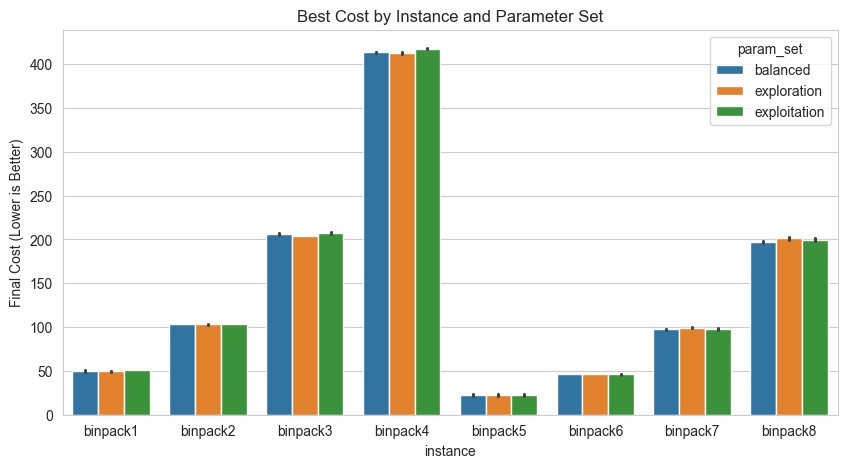

In [907]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=df_results_csv,
    x="instance", y="best_cost",
    hue="param_set", ci="sd"
)
plt.title("Best Cost by Instance and Parameter Set")
plt.ylabel("Final Cost (Lower is Better)")
plt.show()


c. Convergence Behavior (Within Runs)

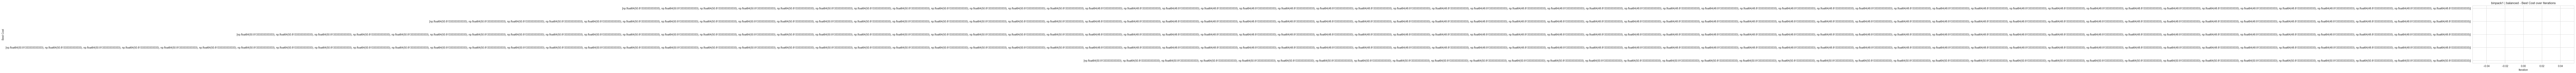

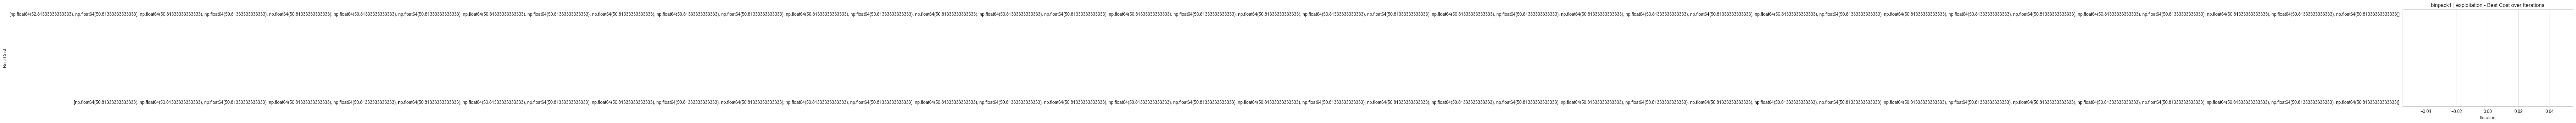

In [ ]:
for (inst, param), group in df_results_csv.groupby(["instance", "param_set"]):
    plt.figure(figsize=(7,4))
    for i, row in group.iterrows():
        plt.plot(row["history_best"], alpha=0.4)
    plt.title(f"{inst} | {param} - Best Cost over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Best Cost")
    plt.show()


d. Pheromone Diversity (τ.std)

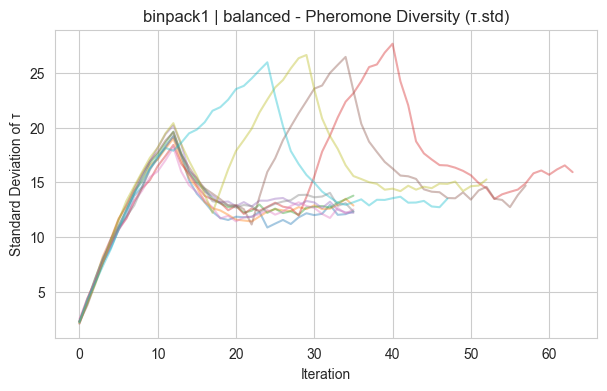

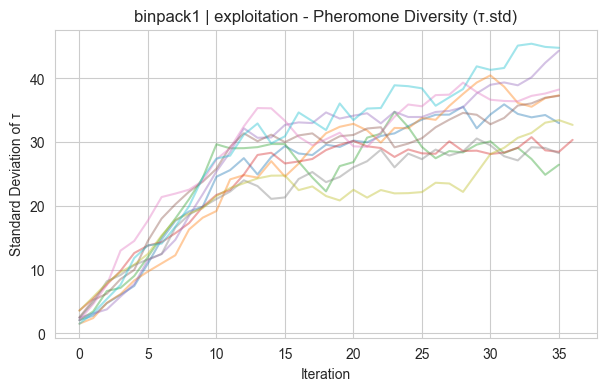

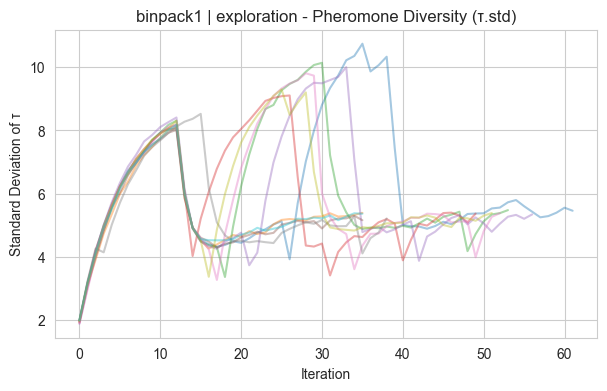

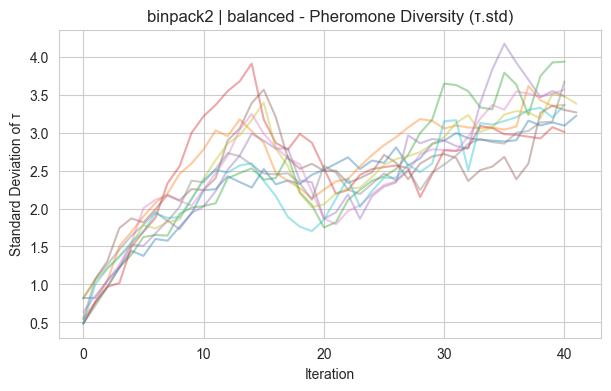

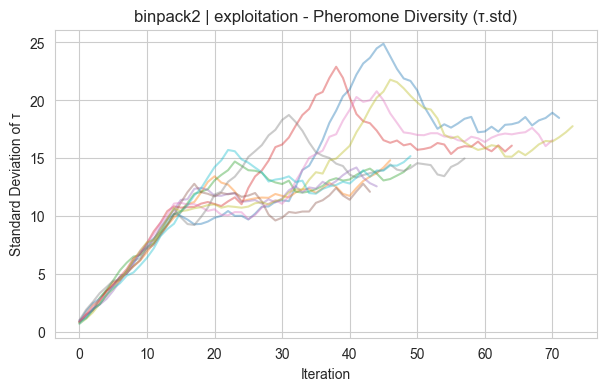

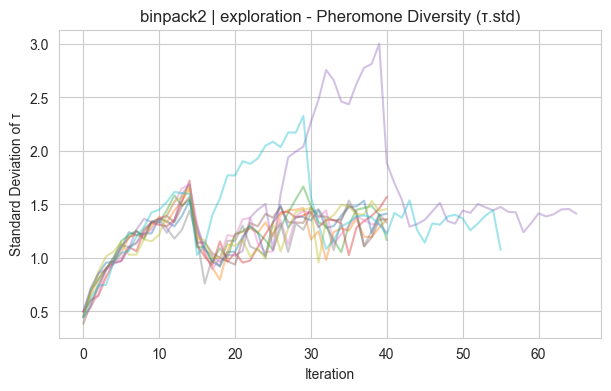

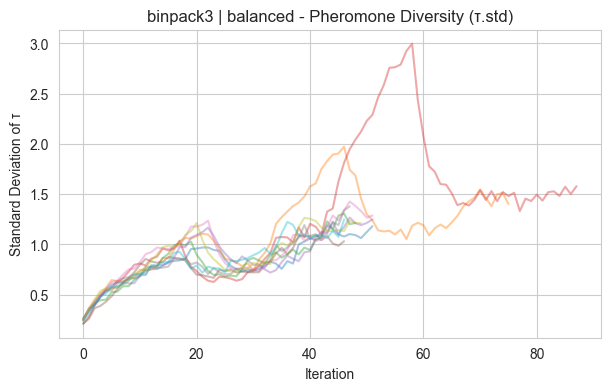

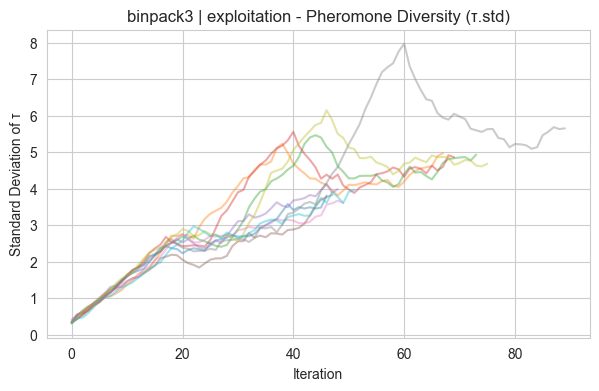

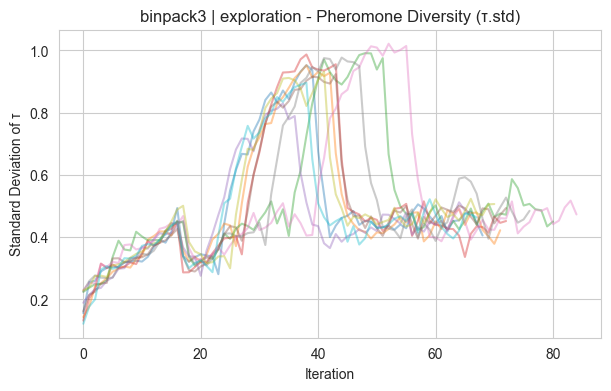

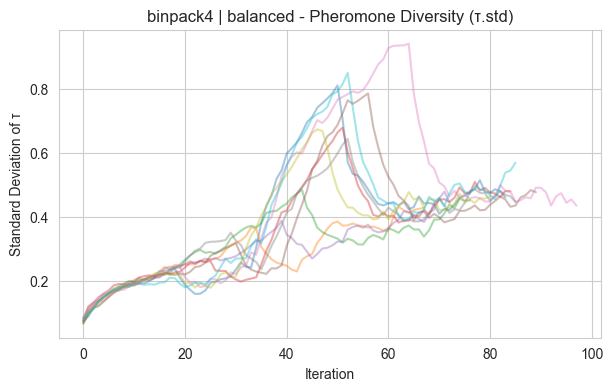

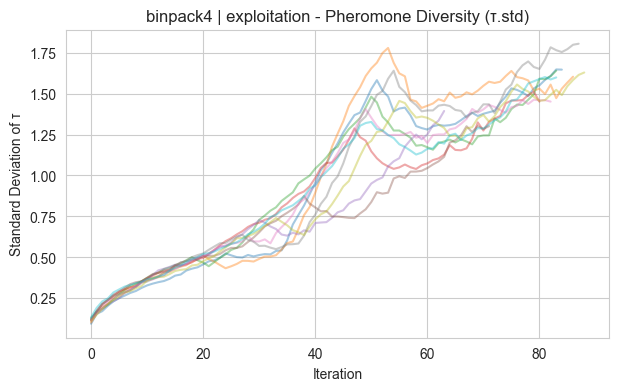

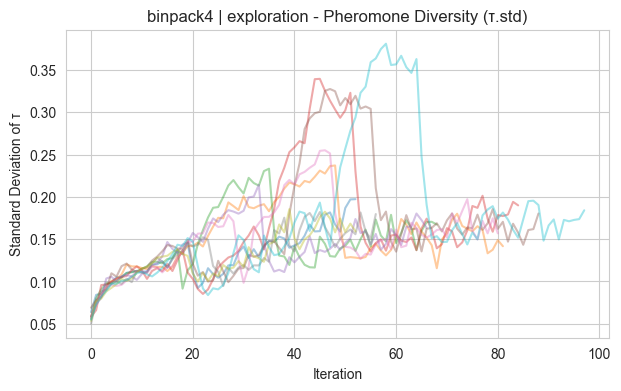

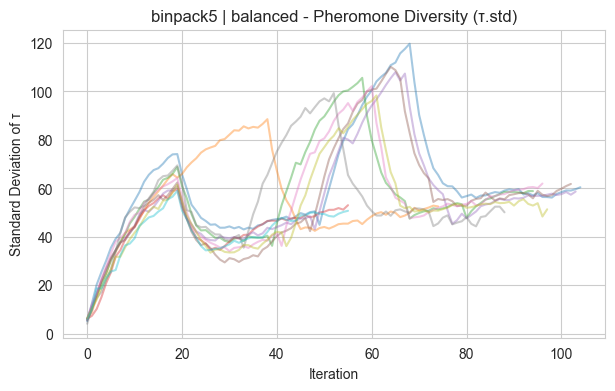

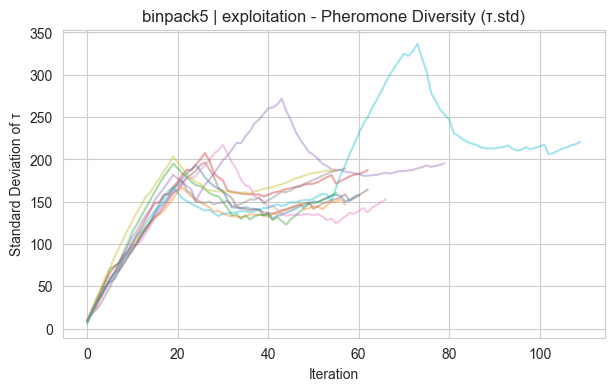

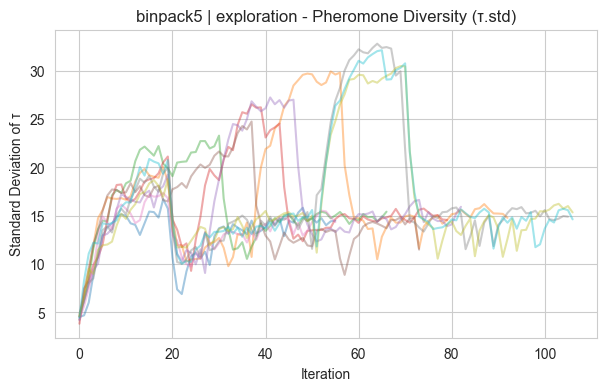

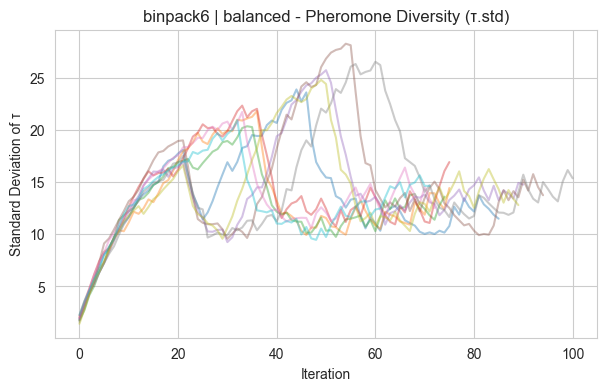

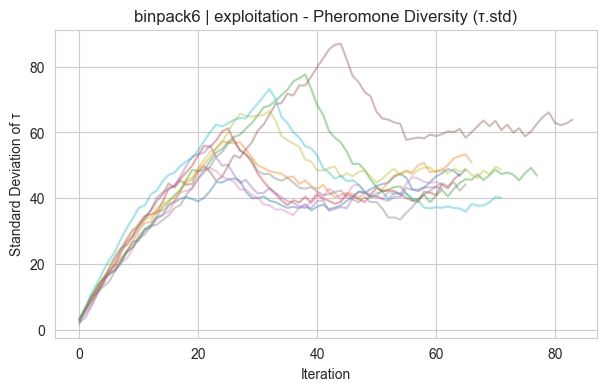

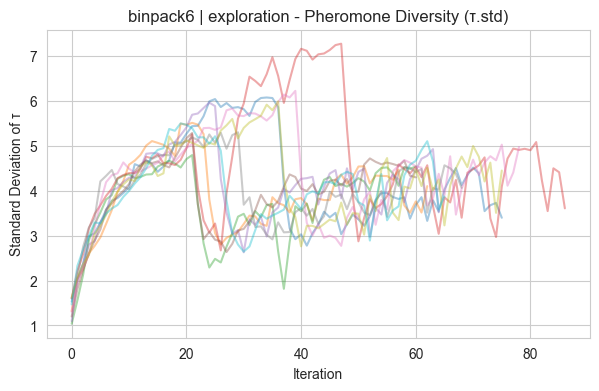

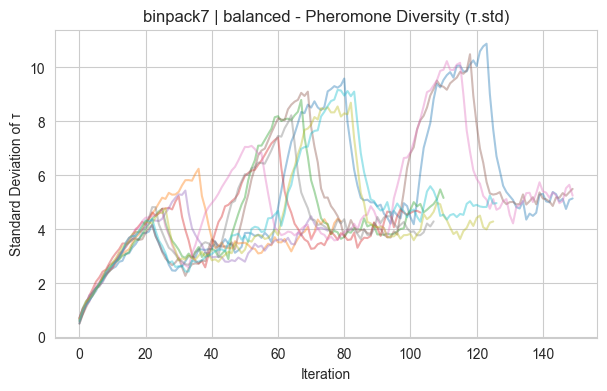

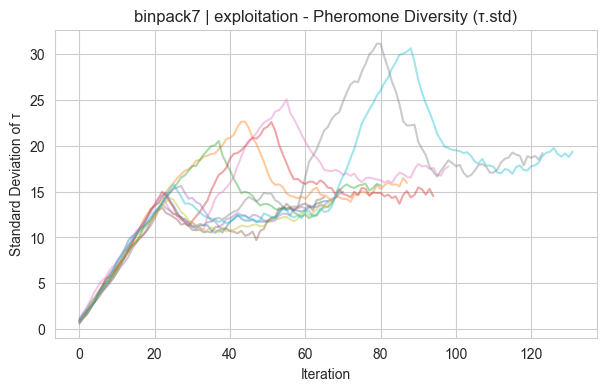

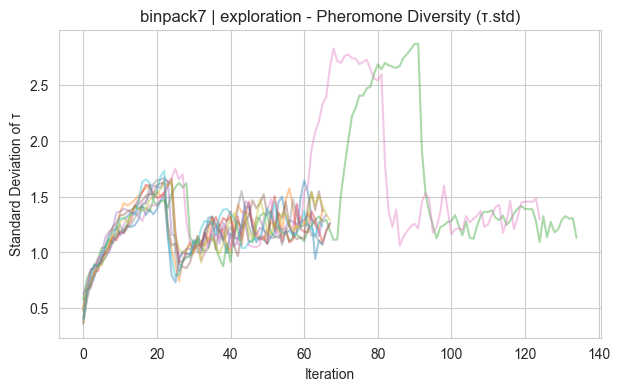

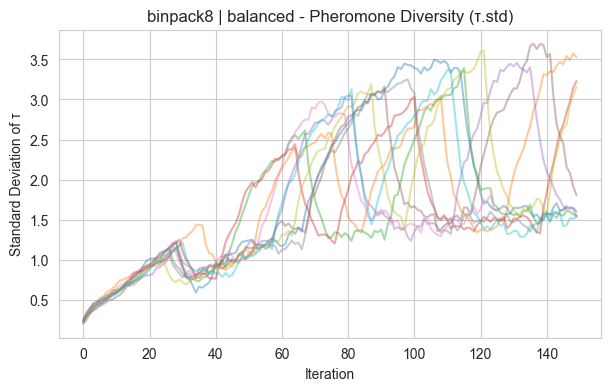

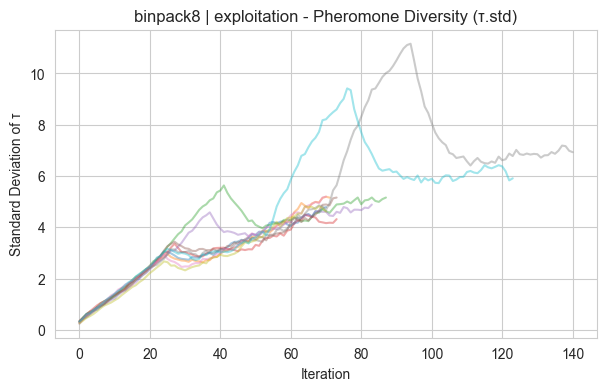

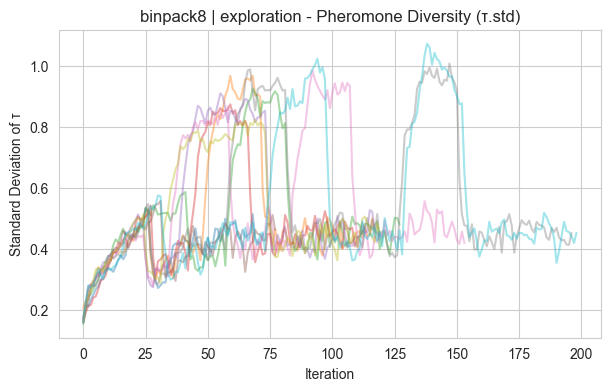

In [899]:
for (inst, param), group in df_results_csv.groupby(["instance", "param_set"]):
    plt.figure(figsize=(7,4))
    for i, row in group.iterrows():
        plt.plot(row["tau_std"], alpha=0.4)
    plt.title(f"{inst} | {param} - Pheromone Diversity (τ.std)")
    plt.xlabel("Iteration")
    plt.ylabel("Standard Deviation of τ")
    plt.show()


e. Explore the Cost Components

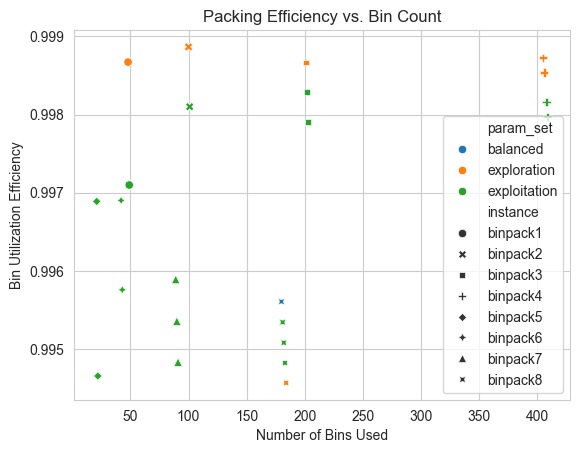

In [900]:
df_results_csv["efficiency"] = 1 - (df_results_csv["unused_capacity"] / (df_results_csv["num_bins"] * df_results_csv["unused_capacity"].max()))
sns.scatterplot(
    data=df_results_csv,
    x="num_bins", y="efficiency",
    hue="param_set", style="instance"
)
plt.title("Packing Efficiency vs. Bin Count")
plt.xlabel("Number of Bins Used")
plt.ylabel("Bin Utilization Efficiency")
plt.show()


f. Identify Patterns Across Instances

In [901]:
summary = (
    df_results_csv.groupby(["instance", "param_set"])["best_cost"]
    .mean().unstack().round(3)
)
print(summary)


param_set  balanced  exploitation  exploration
instance                                      
binpack1     50.013        50.813       49.413
binpack2    103.447       103.447      103.047
binpack3    206.020       207.420      204.420
binpack4    413.373       417.773      412.573
binpack5     22.650        22.450       22.650
binpack6     46.490        46.290       46.490
binpack7     97.400        97.800       99.400
binpack8    197.530       199.930      201.130


g. Deeper Diagnostics

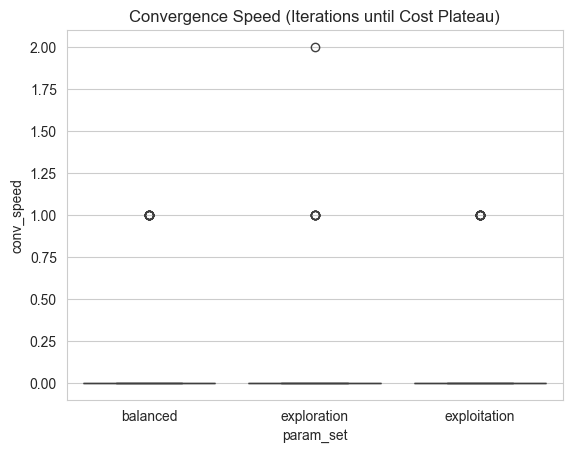

In [902]:
import numpy as np

df_results_csv["conv_speed"] = df_results_csv["history_best"].apply(
    lambda h: np.argmax(np.diff(h) > -0.001) if len(h) > 1 else None
)
sns.boxplot(data=df_results_csv, x="param_set", y="conv_speed")
plt.title("Convergence Speed (Iterations until Cost Plateau)")
plt.show()


## Summary

- Implemented and finalized ACO for 1-D Bin Packing using OR-Library datasets.
- Algorithm finds feasible packings close to or equal to known optima.
- Adjustable parameters (α, β, ρ, Q, ants, iters) allow tuning exploration vs. exploitation.
- Results show stable convergence and efficient performance on standard benchmark sets.
